# Hackathon 2020
## How to: Anomalies
before we find a dataset here

In [1]:
#meta 20190103
# Explore anomalies with Poker dataset


In [2]:
import time as time #to track performance time
import numpy as np
import pandas as pd #for data processing
import matplotlib.pyplot as plt #for plotting
%matplotlib inline

#modeling help
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score  #to cross-validate training data
from sklearn import preprocessing #for onehotencoder
#import category_encoders as ce #transformers for encoding categorical variables into numeric with diff techniques
from sklearn import metrics # to evaluate model


#modeling algos
from sklearn.linear_model import LogisticRegression
#from sklearn import tree
#from sklearn.tree import export_graphviz
#from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.pipeline import Pipeline #streamline Tokenizing + Classification model

#grid search
from sklearn.model_selection import GridSearchCV

#state persistence
from joblib import dump, load #to pickle the model and pipe it to API writing step

#clustering
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity


In [3]:
 #----------------------------------------------- set CONSTANTS and variables -----------------------------------------------
input_verbose_flg = 1

## 0. Load data
from Kaggle

Statistics

      Poker Hand       # of hands	Probability	# of combinations
      Royal Flush      4		0.00000154	480
      Straight Flush   36		0.00001385	4320
      Four of a kind   624		0.0002401	74880
      Full house       3744		0.00144058	449280
      Flush            5108		0.0019654	612960
      Straight         10200		0.00392464	1224000
      Three of a kind  54912		0.02112845	6589440
      Two pairs        123552		0.04753902	14826240
      One pair         1098240		0.42256903	131788800
      Nothing          1302540		0.50117739	156304800

      Total            2598960		1.0		311875200

      The number of combinations represents the number of instances in the entire domain.

CLASS “Poker Hand”
      Ordinal (0-9)

      0: Nothing in hand; not a recognized poker hand 
      1: One pair; one pair of equal ranks within five cards
      2: Two pairs; two pairs of equal ranks within five cards
      3: Three of a kind; three equal ranks within five cards
      4: Straight; five cards, sequentially ranked with no gaps
      5: Flush; five cards with the same suit
      6: Full house; pair + different rank three of a kind
      7: Four of a kind; four equal ranks within five cards
      8: Straight flush; straight + flush
      9: Royal flush; {Ace, King, Queen, Jack, Ten} + flush

In [4]:
df = pd.read_csv("data/train.csv")
print (df.shape)
df.head()

(800000, 11)


,s1,c1,s2,c2,s3,c3,s4,c4,s5,c5,class
0,4,7,3,5,3,3,1,13,4,8,0
1,2,8,4,9,4,6,4,1,3,7,0
2,3,6,1,3,2,11,3,9,2,3,1
3,2,10,2,5,4,13,3,9,1,6,0
4,3,2,1,3,4,7,3,5,1,11,0


In [5]:
#check for nulls
df.isnull().sum()

s1       0
c1       0
s2       0
c2       0
s3       0
c3       0
s4       0
c4       0
s5       0
c5       0
class    0
dtype: int64

In [6]:
#look at types
df.dtypes

s1       int64
c1       int64
s2       int64
c2       int64
s3       int64
c3       int64
s4       int64
c4       int64
s5       int64
c5       int64
class    int64
dtype: object

## 1. Prep Data
Only interested in anomalies  
#### Anomaly definition: Four of a Kind  
i.e. 4 Aces

In [7]:
idx_anomalies = df[df['class']==7].index
df.loc[idx_anomalies].tail()

,s1,c1,s2,c2,s3,c3,s4,c4,s5,c5,class
784282,1,1,4,1,2,7,2,1,3,1,7
792087,1,11,4,9,1,9,2,9,3,9,7
794212,2,3,3,3,1,10,1,3,4,3,7
796455,1,3,1,4,4,3,3,3,2,3,7
799865,2,12,4,12,3,12,1,12,2,3,7


In [8]:
df_tidy = df.copy()
df_tidy['class_4ofakind'] = 0
df_tidy['class_4ofakind'].loc[idx_anomalies] = 1

df_tidy.head()


,s1,c1,s2,c2,s3,c3,s4,c4,s5,c5,class,class_4ofakind
0,4,7,3,5,3,3,1,13,4,8,0,0
1,2,8,4,9,4,6,4,1,3,7,0,0
2,3,6,1,3,2,11,3,9,2,3,1,0
3,2,10,2,5,4,13,3,9,1,6,0,0
4,3,2,1,3,4,7,3,5,1,11,0,0


### 1.1 Vis 
Look at distributions

class
0    400573
1    338169
2     38173
3     16988
4      3126
5      1620
6      1150
7       189
8        10
9         2
dtype: int64


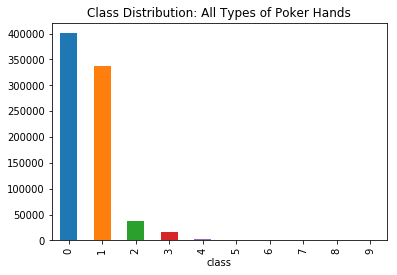

In [9]:
df_grp = df.groupby('class').size()
print(df_grp)
df_grp.plot.bar(title='Class Distribution: All Types of Poker Hands')

class_4ofakind
0    799811
1       189
dtype: int64


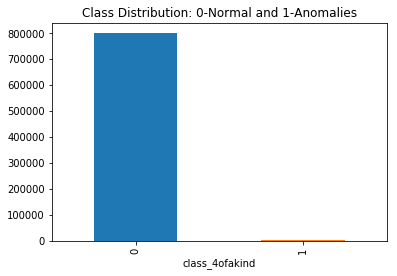

In [10]:
df_tidy_grp = df_tidy.groupby('class_4ofakind').size()
print(df_tidy_grp)
df_tidy_grp.plot.bar(title='Class Distribution: 0-Normal and 1-Anomalies')

Looks like '4 of a kind' poker hands can be considered an anomaly!

### 1.2 Prep data for ML
- Categorical data


In [11]:
#handle data types - categories
for col in df_tidy.columns: 
    df_tidy.loc[:,col]= df_tidy[col].fillna('UNK').astype('category')
    
#check new types
df_tidy.dtypes

s1                category
c1                category
s2                category
c2                category
s3                category
c3                category
s4                category
c4                category
s5                category
c5                category
class             category
class_4ofakind    category
dtype: object

### 1.2a Prep Smaller Data for ML
to build POC models faster

In [12]:
#drop rows for faster performance during POC
df_temp = df_tidy[~df_tidy.index.isin(idx_anomalies)].sample(n=5000, random_state=24).copy()
print (df_temp.shape)

df_tidy = pd.concat([df_temp, df_tidy.loc[idx_anomalies]] )
print('Smaller dataset for modeling: ')
df_tidy.shape

(5000, 12)
Smaller dataset for modeling: 


(5189, 12)

class_4ofakind
0    5000
1     189
dtype: int64


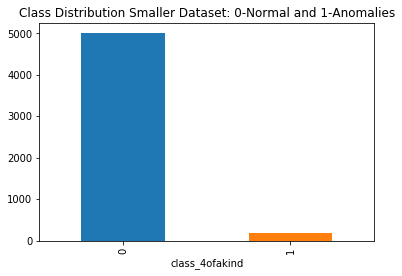

In [13]:
df_tidy_grp = df_tidy.groupby('class_4ofakind').size()
print(df_tidy_grp)

df_tidy_grp.plot.bar(title='Class Distribution Smaller Dataset: 0-Normal and 1-Anomalies')

#### Build X and y

In [14]:
#define columns in
#X_cols = ['s1', 'c1', 's2', 'c2', 's3', 'c3', 's4', 'c4', 's5', 'c5']
X_cols = ['c1', 'c2', 'c3', 'c4', 'c5']
X = df_tidy[X_cols].copy()
X.head()

,c1,c2,c3,c4,c5
90895,12,11,2,4,1
326371,6,9,13,13,6
594585,4,9,3,11,12
238879,13,10,7,3,5
777970,4,10,6,7,3


In [15]:
y = df_tidy['class_4ofakind']
y.head()

90895     0
326371    0
594585    0
238879    0
777970    0
Name: class_4ofakind, dtype: category
Categories (2, int64): [0, 1]

- Split X into train and test portions (shared)


In [16]:
### Train/Test Split
# Randomly split data into two groups: a training set and a validation set
# It's important not to touch the test set when building a classifier. 
#Therefore, we separate X&y into two sets: for training the model and for testing the model accuracy. 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=24)

#done - print summary 
print ("\nTotal records in learning set: {}".format(df_tidy.shape[0]))
print ("Total records in training set: {}".format(len(X_train)))
print ("Total records in test set: {}".format(len(X_test)))
    
#notice index after reshuffling
X_train.head()
X_train.tail()


Total records in learning set: 5189
Total records in training set: 3632
Total records in test set: 1557


,c1,c2,c3,c4,c5
293447,10,5,4,7,6
583730,12,11,12,1,5
748988,10,13,4,13,11
383404,3,10,6,2,2
256532,13,11,3,13,2


In [17]:
#save tidy indices
idx_X_train = X_train.index
idx_y_train =y_train.index
idx_X_test = X_test.index
idx_y_test =y_test.index

#confirm that indices match
print((idx_X_test != idx_y_test).sum())
print((idx_X_train != idx_y_train).sum())

0
0


- Transform categorical features  
Use sklearn encoders here, in other cases may require more sophisticated categorical_encoders.

In [18]:
'''#Transform cols
# Instantiate encoder/scaler, for both models A&B
ohe = ce.OneHotEncoder(handle_unknown='indicator', cols = X_cols, use_cat_names=True)

X_train_ohe = ohe.fit_transform(X_tidy_train) #many features
X_train_ohe.head()
'''

"#Transform cols\n# Instantiate encoder/scaler, for both models A&B\nohe = ce.OneHotEncoder(handle_unknown='indicator', cols = X_cols, use_cat_names=True)\n\nX_train_ohe = ohe.fit_transform(X_tidy_train) #many features\nX_train_ohe.head()\n"

In [19]:
# binary encoder
#ohe = None
ohe = preprocessing.OneHotEncoder(handle_unknown='ignore',  dtype=np.int)

X_train_ohe = ohe.fit_transform(X_train) 
print(X_train_ohe.__class__)
print("OHE categories: ", ohe.categories_)



<class 'scipy.sparse.csr.csr_matrix'>
OHE categories:  [array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=int64), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=int64), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=int64), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=int64), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=int64)]


- Preview X_train matrix

In [20]:
#preview
X_train_ohe.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

- Transform test dataset  
Preview X_test matrix

In [21]:
X_test_ohe = ohe.transform(X_test)
X_test_ohe.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

#### Preview features and class labels

In [22]:
#list of columns vs list features
print ("cols: ", X_cols)
print("Features: ")
ohe.get_feature_names(['c1','c2','c3','c4','c5'])

cols:  ['c1', 'c2', 'c3', 'c4', 'c5']
Features: 


array(['c1_1', 'c1_2', 'c1_3', 'c1_4', 'c1_5', 'c1_6', 'c1_7', 'c1_8',
       'c1_9', 'c1_10', 'c1_11', 'c1_12', 'c1_13', 'c2_1', 'c2_2', 'c2_3',
       'c2_4', 'c2_5', 'c2_6', 'c2_7', 'c2_8', 'c2_9', 'c2_10', 'c2_11',
       'c2_12', 'c2_13', 'c3_1', 'c3_2', 'c3_3', 'c3_4', 'c3_5', 'c3_6',
       'c3_7', 'c3_8', 'c3_9', 'c3_10', 'c3_11', 'c3_12', 'c3_13', 'c4_1',
       'c4_2', 'c4_3', 'c4_4', 'c4_5', 'c4_6', 'c4_7', 'c4_8', 'c4_9',
       'c4_10', 'c4_11', 'c4_12', 'c4_13', 'c5_1', 'c5_2', 'c5_3', 'c5_4',
       'c5_5', 'c5_6', 'c5_7', 'c5_8', 'c5_9', 'c5_10', 'c5_11', 'c5_12',
       'c5_13'], dtype=object)

In [23]:
y.unique()

[0, 1]
Categories (2, int64): [0, 1]

In [24]:
#interrupt
df100

NameError: name 'df100' is not defined

### 2. ML for Anomalies

#### 2.1 Classifiers

In [ ]:
# prepare hyper-parameters for grid search

# The alpha is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%.
alphas = (1e-2, 1e-3) #(.001, .01, .1, 1) #actodo try smaller (0.00001, 0.000001) 
penalties = ('l1', 'l2', 'elasticnet')
penalties_logr = ('l1', 'l2')
tolerances = (0.01, 0.001) #( 1e-3, 1e-4)
Cs = (1, 1e2, 1e3, 1e4, 1e5)
##solvers = ('lbfgs', 'liblinear')
max_iters = (100, 1000, 10000)
criteria = ('gini','entropy')
#oob_scores: [False, True]
n_estimators =  (100, 150) #(150, 250)
min_samples_splits = (20, 40) #(3, 5, 7)
min_samples_leaves = (5, 10) #(10, 12, 14, 16)
max_depth = ( 20, 25) #15
#max_depth = (4, 5) #$note use if want a limited decision tree to demo/test prediction given the pickled model
max_features = (0.75, 0.8, 0.85)
max_leaf_nodes = ( 50, 100, 500, 800)
i_random_state = [24]
subsamples = [0.8, 1.0]

In [ ]:
#input for model 20PCT
print ("\nParameters for training a classifier model...")

# prompt to select a classifier
while True:
    inp = input("Select learning algorithm: (LogR)-Logistic Regression or (GBM)-Gradient Boosting or (SGD)-Stochastic Gradient Descent: ") 
    if inp.lower() not in ('logr','gbm','sgd'):
         print ("Please select a valid algorithm: (LogR)-Logistic Regression or (GBM)-Gradient Boosting or (SGD)-Stochastic Gradient Descent ")
    else:
        input_algorithm_model=inp.upper()
        break

In [ ]:
# choose an algo

#--Logistic Regression
if input_algorithm_model =='LOGR':
    #the grid of parameters to search over
    param_grid = [
        {'penalty': penalties_logr,
         'tol': tolerances,
         'C': Cs,
         'solver': ('liblinear',),
         'max_iter': max_iters         
        },
        {'penalty': ('l2',),
         'tol': tolerances,
         'C': Cs,
         'solver': ('lbfgs',),
         'max_iter': max_iters         
        },
    ]
    
    # declare the classifier
    clf = LogisticRegression()

    
#--Gradient Boosting Classifier
elif input_algorithm_model == 'GBM':
    #the grid of parameters to search over
    
    param_grid = [
        {
         'learning_rate': alphas,
         'random_state': i_random_state,
         'n_estimators': n_estimators, 
         'subsample': subsamples,
         'tol': tolerances,
         'min_samples_split': min_samples_splits,
         'min_samples_leaf': min_samples_leaves,
         'max_depth': max_depth,
         'max_features': max_features
         #'max_leaf_nodes': max_leaf_nodes                 
        }
    ]
    
    # declare the classifier, with early stopping
    # refer https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_early_stopping.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-early-stopping-py
    # # We specify that if the scores don't improve by atleast 0.01 for the last
    # 10 stages, stop fitting additional stages
    clf = GradientBoostingClassifier(validation_fraction=0.2, n_iter_no_change=5)
    

#--Stochastic Gradient Descent
elif input_algorithm_model =='SGD':
    #the grid of parameters to search over
    param_grid = [
        {'alpha': alphas,
         'penalty': penalties,
         'max_iter': max_iters,
         'tol': tolerances
        },
    ]
    
    # declare the classifier
    clf = SGDClassifier()
    
    
# create the GridSearchCV object - find the best parameters for both the feature extraction and the classifier
# n_jobs=-1 grid search will detect how many cores are installed and uses them all
# cv defaults to 3 folds
grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, verbose=input_verbose_flg) # scoring -> refer to https://scikit-learn.org/stable/modules/model_evaluation.html

# fine-tune the hyperparameters
if input_algorithm_model =='LOGR':
    print ("\nStep2: Training a Logistic Regression model...")
elif input_algorithm_model =='GBM':
    print ("\nStep2: Training a Gradient Boosting model...")
elif input_algorithm_model =='SGD':
    print ("\nStep2: Training a Stochastic Gradient Descent model...")
    

# ********************************   FIT MODEL   *****************************************************************
t0 = time.time()
print ("Performing grid search... (this may take many minutes)")
print("parameters:", param_grid)

# fine-tune the hyperparameters
grid_search.fit(X_train_ohe, y_train)

#done - print summary 
t1 = time.time()
print ("Done in %0.3fs" % (t1 - t0))

best_score = grid_search.best_score_
best_parameters = grid_search.best_estimator_.get_params()

print ("Best score: %0.3f" % best_score)
print ("Best parameters set:")
for param_name in sorted(best_parameters.keys()):
    print ("\t%s: %r" % (param_name, best_parameters[param_name]))
        
print("\nProcessing time to fit model (in min): ", (t1 - t0)/60)


### 3. Evaluate Model Performance

In [ ]:
# get the best model
best_clf = grid_search.best_estimator_

In [ ]:
# --------------------------------------------- 3. Evaluate Model Performance ---------------------------------------------
### 3a. Evaluate High Level Accuracy
# run on a test set  
# Report the accuracy of this model on both the training and testing data.  Are results comparable?

print ("\nStep3: Evaluating model performance...")

y_hat=best_clf.predict(X_test_ohe)

#done - print summary 
end=time.time()

accuracy_train=best_clf.score(X_train_ohe, y_train)
accuracy_test=best_clf.score(X_test_ohe, y_test)

print ("Done in %0.3fs" % (t1 - t0))
print ("\nAccuracy on trainset: %0.4f " % accuracy_train)
print ("Accuracy on cv set: %0.4f (aka best score from grid search)" % best_score )
print ("Accuracy on testset: %0.4f " %  accuracy_test)

### 3c. More Analysis on the Model Accuracy:
if input_verbose_flg == 1:
    print ("Total records in testset:", len(X_test_ohe))
    
#confusion matrix
#from sklearn import metrics
    print ("Classified categories: ", best_clf.classes_)
    print ("\nConfusion Matrix" )
    print(metrics.confusion_matrix( y_test, y_hat))

print ("\nClassification Report")
print (metrics.classification_report(y_test, y_hat))

print ("Model built.  Ready to predict.")

 ### 4. Feature Importances

In [ ]:
if input_algorithm_model in ['SGD', 'GBM']:
    print('Feature importance count: ', len(best_clf.feature_importances_))

In [ ]:
if input_algorithm_model in ['SGD', 'GBM']:
    #display top N features
    top_n = 50
    # Plot the feature importances of the forest
    plt.figure()
    plt.figure(figsize=(20, 8))
    plt.title("Feature importances - Best Estimator")
    plt.bar(np.arange(top_n), best_clf_importances[best_clf_indices[:top_n]], color="r")
    #plot with std
    #plt.bar(np.arange(top_n), clf_rf_importances[clf_rf_indices[:top_n]], color="r", yerr=clf_rf_std[clf_rf_indices[:top_n]], align="center")
    #custom ticker
    #refer https://matplotlib.org/gallery/ticks_and_spines/custom_ticker1.html#sphx-glr-gallery-ticks-and-spines-custom-ticker1-py
    plt.xticks(np.arange(top_n), np.asarray(X_features)[best_clf_indices[:top_n]], rotation='vertical')
    #plt.xlim([-1, X_train_scaled.shape[1]])
    plt.show()

 ### 5. Pickle the Model

In [ ]:
dump(best_clf, "models/model_logr.pkl")
dump(X_cols, "models/dataprep_cols_in.pkl")
dump(ohe, "models/datatransform_OneHotEncoder.pkl")


#### 2.1 Clustering approaches
https://sdsawtelle.github.io/blog/output/week9-anomaly-andrew-ng-machine-learning-with-python.html

Jaccard
https://stackoverflow.com/questions/37003272/how-to-compute-jaccard-similarity-from-a-pandas-dataframe

In [31]:
print(jaccard_similarity_score(X_train['c1'], X_train['c2']))

0.08480176211453745


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [33]:
jac_sim = 1 - pairwise_distances(X_train.T, metric = "hamming")
print(jac_sim)

[[1.         0.08480176 0.07406388 0.08094714 0.08562775]
 [0.08480176 1.         0.07351322 0.0779185  0.08232379]
 [0.07406388 0.07351322 1.         0.07213656 0.07929515]
 [0.08094714 0.0779185  0.07213656 1.         0.07736784]
 [0.08562775 0.08232379 0.07929515 0.07736784 1.        ]]


In [34]:
# optionally convert it to a DataFrame
jac_sim = pd.DataFrame(jac_sim, index=X_train.columns, columns=X_train.columns)
jac_sim

### for Hackathon
limited work just to get numbers for Hackathon

In [50]:
X_outliers = X.loc[idx_anomalies].copy()
print(X_outliers.shape)
X_outliers.head()

(189, 5)


,c1,c2,c3,c4,c5
312,12,10,10,10,10
6839,8,4,4,4,4
18114,3,3,12,3,3
18464,11,11,6,11,11
26212,12,13,13,13,13


In [51]:
X_tiny = pd.concat([X[:4], X_outliers[:4]])
print(X_tiny.shape)
X_tiny

(8, 5)


,c1,c2,c3,c4,c5
90895,12,11,2,4,1
326371,6,9,13,13,6
594585,4,9,3,11,12
238879,13,10,7,3,5
312,12,10,10,10,10
6839,8,4,4,4,4
18114,3,3,12,3,3
18464,11,11,6,11,11


In [53]:
arr_tiny = np.sort(np.array(X_tiny, dtype=int))
arr_tiny

array([[ 1,  2,  4, 11, 12],
       [ 6,  6,  9, 13, 13],
       [ 3,  4,  9, 11, 12],
       [ 3,  5,  7, 10, 13],
       [10, 10, 10, 10, 12],
       [ 4,  4,  4,  4,  8],
       [ 3,  3,  3,  3, 12],
       [ 6, 11, 11, 11, 11]])

In [57]:
print(cosine_similarity(arr_tiny, arr_tiny))

[[1.         0.94200009 0.95782159 0.96757364 0.82141484 0.87805411
  0.87266171 0.84274983]
 [0.94200009 1.         0.98874602 0.9862154  0.95971323 0.95733847
  0.86784608 0.96379916]
 [0.95782159 0.98874602 1.         0.99066026 0.92153946 0.93613445
  0.87068149 0.94256588]
 [0.96757364 0.9862154  0.99066026 1.         0.92780189 0.96106741
  0.91770774 0.94195909]
 [0.82141484 0.95971323 0.92153946 0.92780189 1.         0.9701425
  0.84366149 0.98145272]
 [0.87805411 0.95733847 0.93613445 0.96106741 0.9701425  1.
  0.9486833  0.94576485]
 [0.87266171 0.86784608 0.87068149 0.91770774 0.84366149 0.9486833
  1.         0.81388196]
 [0.84274983 0.96379916 0.94256588 0.94195909 0.98145272 0.94576485
  0.81388196 1.        ]]


In [58]:
#prove that when only 4 cards Cosine similarity works perfectly
arr_4cards = arr_tiny[:,0:4]
print(arr_4cards)
print(cosine_similarity(arr_4cards, arr_4cards))

[[ 1  2  4 11]
 [ 6  6  9 13]
 [ 3  4  9 11]
 [ 3  5  7 10]
 [10 10 10 10]
 [ 4  4  4  4]
 [ 3  3  3  3]
 [ 6 11 11 11]]
[[1.         0.92128525 0.93573351 0.93671447 0.75526322 0.75526322
  0.75526322 0.81082418]
 [0.92128525 1.         0.98387692 0.9928041  0.94737296 0.94737296
  0.94737296 0.95971893]
 [0.93573351 0.98387692 1.         0.99108955 0.89602647 0.89602647
  0.89602647 0.93702188]
 [0.93671447 0.9928041  0.99108955 1.         0.92402659 0.92402659
  0.92402659 0.96219114]
 [0.75526322 0.94737296 0.89602647 0.92402659 1.         1.
  1.         0.97622104]
 [0.75526322 0.94737296 0.89602647 0.92402659 1.         1.
  1.         0.97622104]
 [0.75526322 0.94737296 0.89602647 0.92402659 1.         1.
  1.         0.97622104]
 [0.81082418 0.95971893 0.93702188 0.96219114 0.97622104 0.97622104
  0.97622104 1.        ]]


In [ ]:
#$ac stopped here
#next wanted to define an anomaly and loop over all others
#no time to finish

### Xtra.  Example 
https://stackoverflow.com/questions/37003272/how-to-compute-jaccard-similarity-from-a-pandas-dataframe

In [37]:
np.random.seed(0)
df = pd.DataFrame(np.random.binomial(1, 0.5, size=(100, 5)), columns=list('ABCDE'))
print(df.head(6))
print(jaccard_similarity_score(df['A'], df['B']))

   A  B  C  D  E
0  1  1  1  1  0
1  1  0  1  1  0
2  1  1  1  1  0
3  0  0  1  1  1
4  1  1  0  1  0
5  1  0  1  1  0
0.43


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [39]:
#print(1 - pairwise_distances(df.T, metric = "hamming"))
jac_sim = 1 - pairwise_distances(df.T, metric = "hamming")
jac_sim = pd.DataFrame(jac_sim, index=df.columns, columns=df.columns)
jac_sim

,A,B,C,D,E
A,1.00,0.43,0.61,0.55,0.46
B,0.43,1.00,0.52,0.56,0.49
C,0.61,0.52,1.00,0.48,0.53
D,0.55,0.56,0.48,1.00,0.49
E,0.46,0.49,0.53,0.49,1.00


#### 2.2 Other Anomaly Detection Techniques
https://medium.com/learningdatascience/anomaly-detection-techniques-in-python-50f650c75aaf

In [40]:
from sklearn import svm
clf=svm.OneClassSVM(nu=.2,kernel='rbf',gamma=.001)
clf.fit(X_train_ohe)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.001, kernel='rbf',
            max_iter=-1, nu=0.2, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

In [41]:
#predict
y_hat=clf.predict(X_test_ohe)
y_hat

array([-1, -1,  1, ..., -1,  1, -1], dtype=int64)

In [42]:
clf.score_samples(X_test_ohe)

array([719.7261084 , 719.7260028 , 719.72626214, ..., 719.72596889,
       719.72632422, 719.72598236])

In [43]:
clf.decision_function(X_test_ohe)

array([-2.47372634e-05, -1.30334894e-04,  1.29003203e-04, ...,
       -1.64249030e-04,  1.91089210e-04, -1.50774836e-04])

In [45]:
n_errors = (y_hat == y_test).sum()
n_errors

21

In [47]:
print (y_hat[-10:])
y_test[-10:]

[-1  1 -1  1 -1  1 -1 -1  1 -1]


342135    0
187826    0
481200    0
47823     0
46177     0
107246    0
646443    0
299799    0
134586    1
188793    0
Name: class_4ofakind, dtype: category
Categories (2, int64): [0, 1]